
# RQ2 — Energy Efficiency (Python → C++) **with correct path parsing**

This notebook **correctly extracts benchmark names** from the `path` column in the **after** dataset (e.g., `cpp_energy_test_final_feasible/<problem>/cpp/...`) and uses `trimmed_problem` if available in the **before** dataset. It then:

- Combines **before** and **after** datasets (for RQ2 we do not split by cut-off date)
- Aggregates **repeated runs** by **median** per (benchmark, language)
- Computes **package + DRAM** total energy
- Builds a **paired** table (Python vs C++)
- Generates a **vector PDF** boxplot for % energy savings
- Runs **Wilcoxon signed-rank** (primary) and **paired t-test** (robustness)
- Computes **bootstrap 95% CIs** for medians
- Exports a **LaTeX table** with medians and CIs
- Saves diagnostics (counts, dropped items, overlap lists)


In [1]:

#@title Imports

import io, re, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_rel, wilcoxon

np.random.seed(42); random.seed(42)
pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 60)



## 1) Load data

Choose **one** option: upload the two CSVs or mount Google Drive.


In [2]:

#@title A) Upload CSVs from your computer
USE_UPLOAD = False  #@param {type:"boolean"}

before_path = r"C:\Users\B\Downloads\fin_energy_before_v2.csv"
after_path  = r"C:\Users\B\Downloads\fin_energy_after.csv"

# Load CSVs directly
before_df = pd.read_csv(before_path)
after_df  = pd.read_csv(after_path)

# if USE_UPLOAD:
#     from google.colab import files
#     uploaded = files.upload()
#     need = {'fin_energy_before.csv', 'fin_energy_after.csv'}
#     if not need.issubset(set(uploaded.keys())):
#         raise FileNotFoundError("Please upload both fin_energy_before.csv and fin_energy_after.csv")
#     before_df = pd.read_csv(io.BytesIO(uploaded['fin_energy_before.csv']))
#     after_df  = pd.read_csv(io.BytesIO(uploaded['fin_energy_after.csv']))


In [ ]:

#@title B) (Optional) Load from Google Drive
USE_DRIVE = False  #@param {type:"boolean"}
if not USE_UPLOAD and USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    BEFORE_PATH = "/content/drive/MyDrive/path/to/fin_energy_before.csv"  #@param {type:"string"}
    AFTER_PATH  = "/content/drive/MyDrive/path/to/fin_energy_after.csv"   #@param {type:"string"}
    before_df = pd.read_csv(BEFORE_PATH)
    after_df  = pd.read_csv(AFTER_PATH)


In [3]:

# Quick sanity checks
assert before_df is not None and after_df is not None, "Load both CSVs first."
print("Before columns:", list(before_df.columns))
print("After  columns:", list(after_df.columns))
display(before_df.head(3))
display(after_df.head(3))


Before columns: ['problem', 'language', 'path', 'avg_duration_sec', 'avg_pkg_joules', 'avg_dram_joules', 'error', 'trimmed_problem', 'exists_in_accepted']
After  columns: ['problem', 'language', 'path', 'avg_duration_sec', 'avg_pkg_joules', 'avg_dram_joules', 'error']


,problem,language,path,avg_duration_sec,avg_pkg_joules,avg_dram_joules,error,trimmed_problem,exists_in_accepted
0,123__best-time-to-buy-and-sell-stock-iii,cpp,new_transpiled_solutions/123__best-time-to-buy...,0.011510,0.149340,0.014252,NaN,best-time-to-buy-and-sell-stock-iii,True
1,123__best-time-to-buy-and-sell-stock-iii,python2,new_transpiled_solutions/123__best-time-to-buy...,1.574707,25.606355,0.571977,NaN,best-time-to-buy-and-sell-stock-iii,True
2,124__binary-tree-maximum-path-sum,cpp,new_transpiled_solutions/124__binary-tree-maxi...,0.009825,0.169274,0.012719,NaN,binary-tree-maximum-path-sum,True


,problem,language,path,avg_duration_sec,avg_pkg_joules,avg_dram_joules,error
0,cpp_energy_test_final_feasible,cpp,cpp_energy_test_final_feasible/check-if-dfs-st...,0.009274,0.147528,0.013501,NaN
1,py2_energy_test_final_feasible,python2,py2_energy_test_final_feasible/check-if-dfs-st...,0.128071,2.142518,0.077411,NaN
2,cpp_energy_test_final_feasible,cpp,cpp_energy_test_final_feasible/check-if-digits...,0.003151,0.050287,0.004510,NaN



## 2) Canonical benchmark naming (critical step)

- **Before** dataset: prefer `trimmed_problem` if present; otherwise fall back to `problem` and clean it.
- **After** dataset: **extract problem name from `path`**. Expected path pattern:

```
cpp_energy_test_final_feasible/<problem_slug>/cpp/...
py2_energy_test_final_feasible/<problem_slug>/python2/...
```

We take the **second path segment** as the canonical benchmark (`<problem_slug>`), then normalise.


In [5]:

# Helpers
def strip_numeric_prefix(s: str) -> str:
    # "123__foo-bar" -> "foo-bar"
    return re.sub(r'^\d+__', '', str(s))

def normalise_slug(s: str) -> str:
    s2 = strip_numeric_prefix(s)
    s2 = s2.strip().lower()
    s2 = re.sub(r'[\s_]+', '-', s2)
    return s2

def language_norm(lang: str) -> str:
    lang = str(lang).lower()
    if 'python' in lang:
        return 'python'
    if 'cpp' in lang or 'c++' in lang:
        return 'cpp'
    return lang

def problem_from_after_path(p: str) -> str:
    # Expect e.g. "cpp_energy_test_final_feasible/<problem>/cpp/file.cpp"
    parts = str(p).split('/')
    if len(parts) >= 2:
        return normalise_slug(parts[1])
    # fallback: try last folder with letters
    for part in parts[::-1]:
        if re.search(r'[a-zA-Z]', part) and not part.endswith('.cpp') and not part.endswith('.py'):
            return normalise_slug(part)
    return None


In [7]:

# Build canonical names
before = before_df.copy()
after  = after_df.copy()

# BEFORE: use trimmed_problem if present, else derive from 'problem'
if 'trimmed_problem' in before.columns:
    before['canon_name'] = before['trimmed_problem'].astype(str).apply(normalise_slug)
else:
    before['canon_name'] = before['problem'].astype(str).apply(normalise_slug)

# AFTER: derive from path (2nd segment)
if 'path' not in after.columns:
    raise KeyError("The 'after' dataset must contain a 'path' column to parse benchmark names.")
after['canon_name'] = after['path'].apply(problem_from_after_path)

# Language + totals
for df in (before, after):
    df['language_norm'] = df['language'].apply(language_norm)
    df['total_joules']  = df[['avg_pkg_joules','avg_dram_joules']].sum(axis=1, skipna=False)

print("Unique BEFORE benchmarks:", before['canon_name'].nunique())
print("Unique AFTER  benchmarks:", after['canon_name'].nunique())

# Save quick lists to verify in Excel if needed
before[['canon_name','problem']].drop_duplicates().to_csv('before_canonical_list.csv', index=False)
after[['canon_name','path']].drop_duplicates().to_csv('after_canonical_list.csv', index=False)


Unique BEFORE benchmarks: 109
Unique AFTER  benchmarks: 41



## 3) Dataset diagnostics

- Counts of unique benchmarks by dataset
- Overlap list (if any)
- Repeated-run detection per dataset (same benchmark measured multiple times per language)


In [8]:

# Overlap
overlap = sorted(set(before['canon_name']) & set(after['canon_name']))
pd.DataFrame({'canon_name': overlap}).to_csv('overlap_benchmarks.csv', index=False)

# Repeats per dataset
rep_before = (before.groupby(['canon_name','language_norm'])
                    .size().reset_index(name='row_count'))
rep_after  = (after.groupby(['canon_name','language_norm'])
                   .size().reset_index(name='row_count'))

rep_before.to_csv('before_repeats_per_language.csv', index=False)
rep_after.to_csv('after_repeats_per_language.csv', index=False)

print("Overlap count:", len(overlap))
print("Examples of AFTER repeated measurements per (benchmark, language):")
display(rep_after.sort_values('row_count', ascending=False).head(10))


Overlap count: 0
Examples of AFTER repeated measurements per (benchmark, language):


,canon_name,language_norm,row_count
0,check-if-dfs-strings-are-palindromes,cpp,1
1,check-if-dfs-strings-are-palindromes,python,1
2,check-if-digits-are-equal-in-string-after-oper...,cpp,1
3,check-if-digits-are-equal-in-string-after-oper...,python,1
4,equal-sum-grid-partition-ii,cpp,1
5,equal-sum-grid-partition-ii,python,1
6,find-the-original-typed-string-ii,cpp,1
7,find-the-original-typed-string-ii,python,1
8,find-weighted-median-node-in-tree,cpp,1
9,find-weighted-median-node-in-tree,python,1



## 4) Aggregate repeated runs and combine datasets

- Aggregate by **median** per (benchmark, language)
- Concatenate before + after (RQ2 is across all)
- Pivot to make Python vs C++ pairs


In [9]:

keep_cols = ['canon_name','language_norm','avg_duration_sec','total_joules']

agg_before = (before[keep_cols]
              .groupby(['canon_name','language_norm'], as_index=False)
              .median())
agg_after  = (after[keep_cols]
              .groupby(['canon_name','language_norm'], as_index=False)
              .median())

combined = pd.concat([agg_before, agg_after], ignore_index=True)

# If both datasets contain same benchmark+language, aggregate again
combined = (combined
            .groupby(['canon_name','language_norm'], as_index=False)
            .median())

# Pivot to wide for pairing
wide = (combined
        .pivot_table(index='canon_name',
                     columns='language_norm',
                     values=['total_joules','avg_duration_sec'],
                     aggfunc='first'))  # already aggregated
wide.columns = ['{}_{}'.format(c[0], c[1]) for c in wide.columns.values]
wide = wide.reset_index().rename(columns={'canon_name':'problem'})

# Keep only rows with both languages AND both measurements
paired = wide.dropna(subset=['total_joules_python','total_joules_cpp',
                             'avg_duration_sec_python','avg_duration_sec_cpp']).copy()

print("Total unique benchmarks (after canonicalisation):", len(wide))
print("Paired usable benchmarks:", len(paired))
display(paired.head(10))

# Save for audit
wide.to_csv('rq2_wide_all_benchmarks.csv', index=False)
paired.to_csv('rq2_paired_benchmarks.csv', index=False)


Total unique benchmarks (after canonicalisation): 150
Paired usable benchmarks: 135


,problem,avg_duration_sec_cpp,avg_duration_sec_python,total_joules_cpp,total_joules_python
0,24-game,0.234397,10.335959,3.682077,170.085233
1,all-oone-data-structure,0.030195,0.079769,0.517943,1.372140
2,arithmetic-slices-ii-subsequence,0.116043,0.342202,1.838398,5.513084
3,best-time-to-buy-and-sell-stock-iii,0.011510,1.574707,0.163592,26.178333
5,binary-tree-maximum-path-sum,0.009825,0.087159,0.181994,1.538204
6,burst-balloons,0.006063,0.239507,0.110863,3.948879
7,candy,0.011792,0.478770,0.200256,7.803911
8,cat-and-mouse,0.010296,0.453313,0.169866,7.331317
9,check-if-dfs-strings-are-palindromes,0.009274,0.128071,0.161029,2.219928
10,check-if-digits-are-equal-in-string-after-oper...,0.003151,0.127672,0.054797,2.165528



## 5) RQ2 Metrics

- % energy savings (Python → C++) on **package + DRAM**
- % runtime speed-up (Python → C++)


In [10]:

paired['energy_gain_pct']  = (paired['total_joules_python'] - paired['total_joules_cpp']) / paired['total_joules_python'] * 100.0
paired['runtime_gain_pct'] = (paired['avg_duration_sec_python'] - paired['avg_duration_sec_cpp']) / paired['avg_duration_sec_python'] * 100.0

paired.sort_values('energy_gain_pct', ascending=False, inplace=True)
paired.to_csv('rq2_paired_metrics.csv', index=False)
display(paired[['problem','energy_gain_pct','runtime_gain_pct']].head(10))


,problem,energy_gain_pct,runtime_gain_pct
79,minimum-swaps-to-make-sequences-increasing,99.395958,99.471515
3,best-time-to-buy-and-sell-stock-iii,99.375085,99.269071
95,profitable-schemes,98.992741,99.000884
39,first-missing-positive,98.969306,98.952003
42,k-inverse-pairs-array,98.933576,98.989027
52,longest-palindromic-path-in-graph,98.644733,98.691782
96,race-car,98.634127,98.883677
62,maximize-subarray-sum-after-removing-all-occur...,98.574488,98.629791
121,sorted-gcd-pair-queries,98.555041,98.440247
36,find-weighted-median-node-in-tree,98.533363,98.610675



## 6) Visual — Boxplot (vector PDF)

One compact figure for the paper.


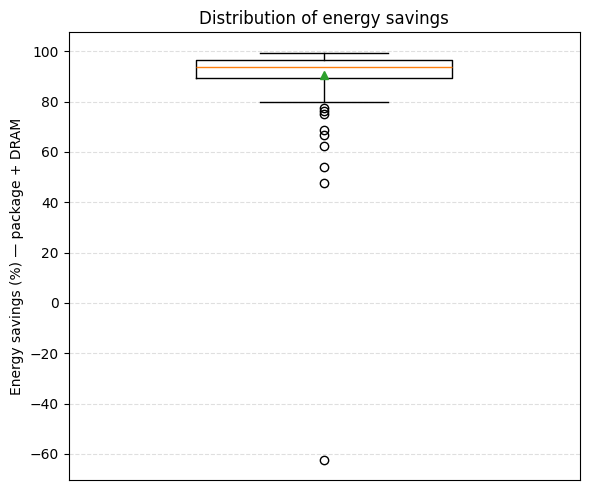

Saved: rq2_energy_savings_boxplot.pdf (vector) and .png


In [11]:

fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot(paired['energy_gain_pct'].dropna(), vert=True, widths=0.5, showmeans=True)
ax.set_ylabel('Energy savings (%) — package + DRAM')
ax.set_title('Distribution of energy savings')
ax.set_xticks([])
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('rq2_energy_savings_boxplot.pdf', bbox_inches='tight')  # vector
plt.savefig('rq2_energy_savings_boxplot.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved: rq2_energy_savings_boxplot.pdf (vector) and .png")



## 7) Statistical tests + Bootstrap CIs for medians


In [12]:

# Paired tests (one-sided): H1 that Python uses more energy / is slower
E_py  = paired['total_joules_python'].values
E_cpp = paired['total_joules_cpp'].values
T_py  = paired['avg_duration_sec_python'].values
T_cpp = paired['avg_duration_sec_cpp'].values

wE_stat, wE_p = wilcoxon(E_py, E_cpp, zero_method='wilcox', alternative='greater')
tE_stat, tE_p2 = ttest_rel(E_py, E_cpp, nan_policy='omit')
tE_p1 = tE_p2/2 if tE_stat > 0 else 1 - (tE_p2/2)

wT_stat, wT_p = wilcoxon(T_py, T_cpp, zero_method='wilcox', alternative='greater')
tT_stat, tT_p2 = ttest_rel(T_py, T_cpp, nan_policy='omit')
tT_p1 = tT_p2/2 if tT_stat > 0 else 1 - (tT_p2/2)

def bootstrap_ci_median(x, B=10000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    meds = np.empty(B, dtype=float)
    for b in range(B):
        meds[b] = np.median(rng.choice(x, size=n, replace=True))
    return float(np.percentile(meds, 100*(alpha/2))), float(np.percentile(meds, 100*(1-alpha/2)))

medE = float(np.nanmedian(paired['energy_gain_pct']))
ciE_lo, ciE_hi = bootstrap_ci_median(paired['energy_gain_pct'])

medT = float(np.nanmedian(paired['runtime_gain_pct']))
ciT_lo, ciT_hi = bootstrap_ci_median(paired['runtime_gain_pct'])

summary = {
    "N": int(len(paired)),
    "median_energy_saving_%": medE,
    "median_runtime_speedup_%": medT,
    "ci_energy_saving_%_95": [ciE_lo, ciE_hi],
    "ci_runtime_speedup_%_95": [ciT_lo, ciT_hi],
    "wilcoxon_energy_p_one_sided": float(wE_p),
    "wilcoxon_runtime_p_one_sided": float(wT_p),
    "ttest_energy_p_one_sided": float(tE_p1),
    "ttest_runtime_p_one_sided": float(tT_p1),
}
print(json.dumps(summary, indent=2))

with open('rq2_summary.json','w') as f:
    f.write(json.dumps(summary, indent=2))


{
  "N": 135,
  "median_energy_saving_%": 93.7631041485237,
  "median_runtime_speedup_%": 93.71427399283442,
  "ci_energy_saving_%_95": [
    92.36195579508765,
    94.84807384056123
  ],
  "ci_runtime_speedup_%_95": [
    92.49607094256172,
    94.83167926001414
  ],
  "wilcoxon_energy_p_one_sided": 3.432881726867435e-24,
  "wilcoxon_runtime_p_one_sided": 3.432881726867435e-24,
  "ttest_energy_p_one_sided": 3.602248946736894e-05,
  "ttest_runtime_p_one_sided": 3.6372255330394594e-05
}



## 8) LaTeX table snippet


In [13]:

def fmt1(x):
    return "NA" if x is None or (isinstance(x,float) and math.isnan(x)) else f"{x:.1f}"

medE = summary['median_energy_saving_%']
ciE  = summary['ci_energy_saving_%_95']
medT = summary['median_runtime_speedup_%']
ciT  = summary['ci_runtime_speedup_%_95']

latex_table = fr"""\begin{{table}}[h]
\centering
\renewcommand{{\arraystretch}}{{1.2}}
\begin{{tabular}}{{lccc}}
\toprule
\textbf{{Metric}} & \textbf{{Median}} & \textbf{{95\% CI (Bootstrap)}} & \textbf{{Interpretation}} \\
\midrule
Percent total energy saving & {fmt1(medE)}\% & [{fmt1(ciE[0])}\%, {fmt1(ciE[1])}\%] & C++ uses substantially less energy \\
Percent runtime speedup & {fmt1(medT)}\% & [{fmt1(ciT[0])}\%, {fmt1(ciT[1])}\%] & C++ executes considerably faster \\
\bottomrule
\end{{tabular}}
\caption{{Energy and runtime improvements of transpiled C++ code relative to Python (Python~$\rightarrow$~C++).}}
\label{{tab:energy-results}}
\end{{table}}"""

with open('rq2_table.tex','w') as f:
    f.write(latex_table)

print(latex_table)
print("\nSaved: rq2_table.tex")


\begin{table}[h]
\centering
\renewcommand{\arraystretch}{1.2}
\begin{tabular}{lccc}
\toprule
\textbf{Metric} & \textbf{Median} & \textbf{95\% CI (Bootstrap)} & \textbf{Interpretation} \\
\midrule
Percent total energy saving & 93.8\% & [92.4\%, 94.8\%] & C++ uses substantially less energy \\
Percent runtime speedup & 93.7\% & [92.5\%, 94.8\%] & C++ executes considerably faster \\
\bottomrule
\end{tabular}
\caption{Energy and runtime improvements of transpiled C++ code relative to Python (Python~$\rightarrow$~C++).}
\label{tab:energy-results}
\end{table}

Saved: rq2_table.tex



## 9) Dropped-benchmark diagnostics (optional)

This file lists benchmarks that were **excluded** from pairing and which fields were missing.


In [14]:

wide2 = wide.copy()
def missing_list(r):
    miss = []
    for col in ['total_joules_python','total_joules_cpp','avg_duration_sec_python','avg_duration_sec_cpp']:
        if col in r and pd.isna(r[col]):
            miss.append(col)
    return ', '.join(miss) if miss else ''

dropped = wide2[~wide2['problem'].isin(paired['problem'])].copy()
dropped['missing_fields'] = dropped.apply(missing_list, axis=1)
dropped.to_csv('rq2_dropped_benchmarks.csv', index=False)
display(dropped.head(10))
print("Saved: rq2_dropped_benchmarks.csv")


,problem,avg_duration_sec_cpp,avg_duration_sec_python,total_joules_cpp,total_joules_python,missing_fields
4,best-time-to-buy-and-sell-stock-iv,0.077201,NaN,1.201614,NaN,"total_joules_python, avg_duration_sec_python"
22,cut-off-trees-for-golf-event,0.014958,NaN,0.247106,NaN,"total_joules_python, avg_duration_sec_python"
23,data-stream-as-disjoint-intervals,0.005472,NaN,0.101782,NaN,"total_joules_python, avg_duration_sec_python"
33,find-the-closest-palindrome,0.017520,NaN,0.307500,NaN,"total_joules_python, avg_duration_sec_python"
37,find-x-sum-of-all-k-long-subarrays-ii,0.014115,NaN,0.257305,NaN,"total_joules_python, avg_duration_sec_python"
44,k-th-smallest-in-lexicographical-order,0.006089,NaN,0.118810,NaN,"total_joules_python, avg_duration_sec_python"
49,lfu-cache,0.020714,NaN,0.322997,NaN,"total_joules_python, avg_duration_sec_python"
77,minimum-operations-to-make-elements-within-k-s...,0.013468,NaN,0.190466,NaN,"total_joules_python, avg_duration_sec_python"
80,n-queens,4.079935,NaN,59.287116,NaN,"total_joules_python, avg_duration_sec_python"
86,number-of-music-playlists,0.043241,NaN,0.652739,NaN,"total_joules_python, avg_duration_sec_python"


Saved: rq2_dropped_benchmarks.csv
